In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import GradientTape, exp, keras, reduce_mean, reduce_sum, shape, square
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    Add,
    BatchNormalization,
    Bidirectional,
    Concatenate,
    Conv1D,
    Conv2D,
    ConvLSTM1D,
    Cropping1D,
    Cropping2D,
    Dense,
    Dropout,
    Flatten,
    Input,
    Lambda,
    MaxPooling1D,
    Normalization,
    Reshape,
    ZeroPadding1D,
)
from tensorflow.keras.losses import Huber, binary_crossentropy, mse
from tensorflow.keras.metrics import Mean
from tensorflow.keras.models import Model

2023-10-13 08:44:11.417958: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-13 08:44:12.584636: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
n_el = 16
r_obj = 0.4
dist_exc = 8
step_meas = 1

load_path = f"data/{n_el=}_{r_obj=}_{dist_exc=}_{step_meas=}/"

if os.path.isdir(load_path):
    print("This directory exists...continue")
else:
    print("You have to generate the data...")

You have to generate the data...


In [3]:
V = np.load("saves/" + load_path.split("/")[1] + "_v_data.npy", allow_pickle=True)

In [4]:
V.shape

(499, 192)

In [5]:
latent_dim = 10
nseg = 4

# channels = [8, 4, 1, 1]
# strides = [1, 2, 1, 10]
kernel_size = 4


def encoder_model(latent_dim=10, nseg=4, kernel_size=4):
    def sampling(args):
        z_mean, z_log_var = args
        epsilon = keras.backend.random_normal(
            shape=(keras.backend.shape(z_mean)[0], latent_dim)
        )
        return z_mean + keras.backend.exp(0.5 * z_log_var) * epsilon

    def slice_enconder(s):
        def func(x):
            return x[:, s, :, :]

        return func

    def slice_lstm(s):
        def func(x):
            return x[:, s, :]

        return func

    # start encoder model
    encoder_inputs = keras.Input(shape=(nseg, 192, 1))
    inputs = tf.keras.layers.ZeroPadding2D(padding=((0, 4)))(encoder_inputs)
    print(inputs.shape)

    # Build conv layers for wheight sharing
    conv1d_l1 = Conv1D(8, kernel_size=kernel_size, padding="same", strides=1)
    conv1d_l2 = Conv1D(4, kernel_size=kernel_size, padding="same", strides=2)
    conv1d_l3 = Conv1D(1, kernel_size=kernel_size, padding="same", strides=1)
    conv1d_l4 = Conv1D(1, kernel_size=kernel_size, padding="same", strides=10)

    z_mean_list = list()
    z_var_list = list()
    for s in range(nseg):
        x = Lambda(slice_enconder(s))(inputs)
        x = conv1d_l1(x)
        x = conv1d_l2(x)
        x = conv1d_l3(x)
        x = conv1d_l4(x)
        # x = conv1d(ch_n, kernel_size=kernel_size, padding='same', strides=str_n)(x)
        # x = Conv1D(ch_n, kernel_size=kernel_size, padding='same', strides=str_n)(x)
        # x = BatchNormalization()(x)
        # x = Activation("relu")(x)
        x = Flatten()(x)

        z_mean = layers.Dense(latent_dim, name=f"z_mean_{s}")(x)
        z_log_var = layers.Dense(latent_dim, name=f"z_log_var_{s}")(x)

        z_mean_list.append(z_mean)
        z_var_list.append(z_log_var)

    z_mean = Concatenate(axis=1)(z_mean_list)
    z_mean = Reshape((nseg, int(z_mean.shape[1] / nseg)))(z_mean)

    z_var = Concatenate(axis=1)(z_var_list)
    z_var = Reshape((nseg, int(z_var.shape[1] / nseg)))(z_var)

    # hier LSTMs
    ### mean block
    lstm_list_mean = list()
    for s in range(nseg):
        lstm_mean = Lambda(slice_lstm(s))(z_mean)
        lstm_mean = Dense(10, activation="relu")(lstm_mean)
        lstm_list_mean.append(lstm_mean)
    # concat and reshape for LSTM
    lstm_mean = Concatenate(axis=1)(lstm_list_mean)
    lstm_mean = Reshape((nseg, int(lstm_mean.shape[1] / nseg)))(lstm_mean)
    lstm_mean = LSTM(latent_dim)(lstm_mean)
    lstm_mean = Activation("softmax")(lstm_mean)
    ### mean block

    ### var block
    lstm_list_var = list()
    for s in range(nseg):
        lstm_var = Lambda(slice_lstm(s))(z_var)
        lstm_var = Dense(10, activation="relu")(lstm_var)
        lstm_list_var.append(lstm_var)
    # concat and reshape for LSTM
    lstm_var = Concatenate(axis=1)(lstm_list_var)
    lstm_var = Reshape((nseg, int(lstm_var.shape[1] / nseg)))(lstm_var)
    lstm_var = LSTM(latent_dim)(lstm_var)
    lstm_var = Activation("softmax")(lstm_var)
    ### var block
    # end LSTM

    z = layers.Lambda(sampling, output_shape=(latent_dim,), name="z")(
        [lstm_mean, lstm_var]
    )

    return encoder_inputs, lstm_mean, lstm_var, z


# encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

In [6]:
def decoder_model(latent_dim=latent_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(100, activation="relu")(latent_inputs)
    x = Reshape((100, 1))(x)
    x = layers.Dense(2, activation="relu")(x)
    x = layers.Flatten()(x)
    x = Reshape((200, 1))(x)
    decoder_outputs = Cropping1D(cropping=(0, 8))(x)
    return latent_inputs, decoder_outputs


# decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
# decoder.summary()

In [7]:
def vae_model():
    encoder_inputs, z_mean, z_log_var, z = encoder_model()
    encoder = Model(encoder_inputs, (z_mean, z_log_var, z), name="VAE_encoder")
    encoder.summary()

    decoder_inputs, decoder_outputs = decoder_model()
    decoder = Model(decoder_inputs, decoder_outputs, name="VAE_decoder")
    decoder.summary()

    return VAE(encoder, decoder)

In [8]:
# creates overlapping segments with a length of nseg
X0 = [V[n : n + nseg, :] for n in range(V.shape[0] - nseg + 1)]  # is this nseg+1 right?
X0 = np.array(X0)

Y0 = np.array(V[nseg - 1 :])  # is this -1 right?

In [9]:
# proof that the shift is right
print(np.allclose(X0[0], V[0:nseg, :]))
print(np.allclose(X0[244], V[244 : 244 + nseg, :]))

True
True


In [10]:
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(name="reconstruction_loss")
        self.kl_loss_tracker = Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)[0]
            print(data[0,0,:].shape, reconstruction[0].shape)
            reconstruction_loss = reduce_mean(reduce_sum(binary_crossentropy(data[0,0,:], reconstruction, axis=1)))
            kl_loss = -0.5 * (1 + z_log_var - square(z_mean) - exp(z_log_var))
            kl_loss = reduce_mean(reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)[0]
        reconstruction_loss = reduce_mean(binary_crossentropy(inputs, reconstruction))
        reconstruction_loss *= 192
        kl_loss = 1 + z_log_var - square(z_mean) - exp(z_log_var)
        kl_loss = reduce_mean(kl_loss)
        kl_loss *= -0.5
        total_loss = reconstruction_loss + kl_loss
        self.add_metric(kl_loss, name='kl_loss', aggregation='mean')
        self.add_metric(total_loss, name='total_loss', aggregation='mean')
        self.add_metric(reconstruction_loss, name='reconstruction_loss', aggregation='mean')
        return reconstruction

In [11]:
vae = vae_model()

(None, 4, 200, 1)


2023-10-13 08:44:31.108924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44477 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:5f:00.0, compute capability: 8.6
2023-10-13 08:44:31.111647: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46672 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:d8:00.0, compute capability: 8.6
2023-10-13 08:44:32.714802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-10-13 08:44:32.715989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (

Model: "VAE_encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 192, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 4, 200, 1)   0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 200, 1)       0           ['zero_padding2d[0][0]']         
                                                                                                  
 lambda_1 (Lambda)              (None, 200, 1)       0           ['zero_padding2d[0][0]']         
                                                                                        

In [12]:
vae.compile(optimizer="adam", loss="MeanSquaredError")

In [16]:
history = vae.fit(x=X0, epochs=100, batch_size=32)

Epoch 1/100
16/16 [==============================] - 0s 24ms/step - loss: 231.6573 - reconstruction_loss: 234.2290 - kl_loss: 0.0761
Epoch 2/100
16/16 [==============================] - 0s 24ms/step - loss: 232.0782 - reconstruction_loss: 222.9086 - kl_loss: 0.0761
Epoch 3/100
16/16 [==============================] - 0s 24ms/step - loss: 253.6599 - reconstruction_loss: 242.8130 - kl_loss: 0.0761
Epoch 4/100
16/16 [==============================] - 0s 24ms/step - loss: 246.9724 - reconstruction_loss: 237.4569 - kl_loss: 0.0760
Epoch 5/100
16/16 [==============================] - 0s 23ms/step - loss: 234.5275 - reconstruction_loss: 237.0456 - kl_loss: 0.0760
Epoch 6/100
16/16 [==============================] - 0s 23ms/step - loss: 248.7679 - reconstruction_loss: 241.3625 - kl_loss: 0.0759
Epoch 7/100
16/16 [==============================] - 0s 24ms/step - loss: 224.9342 - reconstruction_loss: 214.9847 - kl_loss: 0.0759
Epoch 8/100
16/16 [==============================] - 0s 24ms/step - l

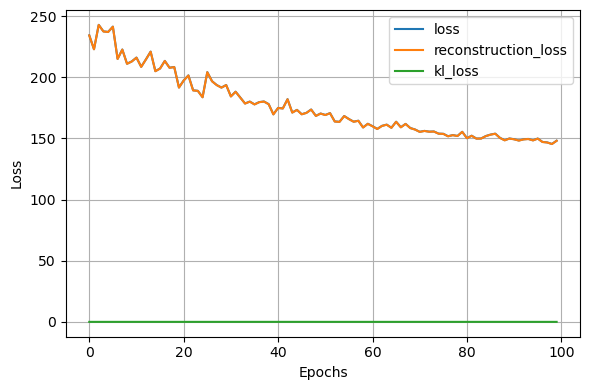

In [17]:
plt.figure(figsize=(6,4))
for key in history.history.keys():
    plt.plot(history.history[key], label = key)
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

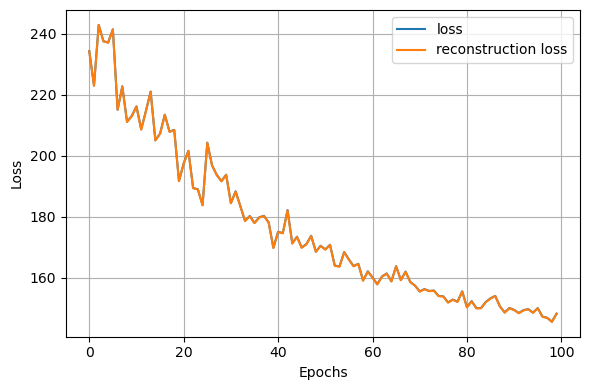

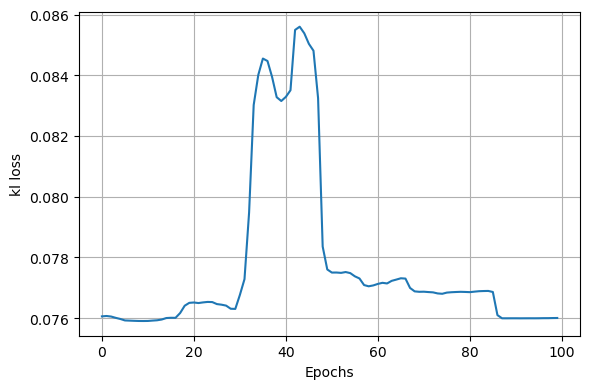

In [20]:
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label = "loss")
plt.plot(history.history["reconstruction_loss"], label = "reconstruction loss")
plt.grid()
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["kl_loss"])
plt.grid()
plt.xlabel("Epochs")
plt.ylabel("kl loss")
plt.tight_layout()
plt.show()